## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.



#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.



### Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
%matplotlib inline


### Read data

In [3]:
df = pd.read_csv('lalonde.csv',index_col=0)
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Analysing the dataset, we find out that there are no missing values and that there are some attributes(`treat`, `black`, `hispan`, `married` and `nodegree`) that are categorical, so we convert this to a category type.

In [4]:
df['treat'] = df.treat.astype('category')
df['black'] = df.black.astype('category')
df['hispan'] = df.hispan.astype('category')
df['married'] = df.married.astype('category')
df['nodegree'] = df.nodegree.astype('category')

df.isnull().any()

treat       False
age         False
educ        False
black       False
hispan      False
married     False
nodegree    False
re74        False
re75        False
re78        False
dtype: bool

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?


### Plot analysis
We first plot, using histograms, the distribution of the variable `re78` in the two groups.

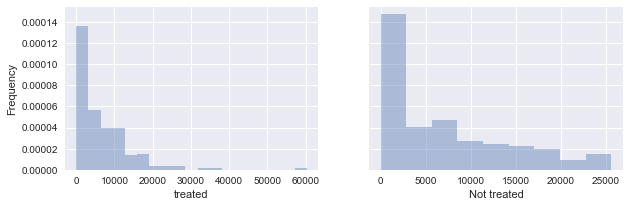

In [41]:
#divide the two groups and plot
treat = df[df.treat == 1]
notreat = df[df.treat == 0]

treat_re78 = treat[['re78']]
notreat_re78 = notreat[['re78']]

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 3));
sns.distplot(norm_hist=True, ax=ax[0], kde=False, a=treat_re78)
ax[0].set_xlabel('treated')
sns.distplot(norm_hist=True, ax=ax[1], kde=False, a=notreat_re78)
ax[0].set_ylabel('Frequency')
ax[1].set_xlabel('Not treated')

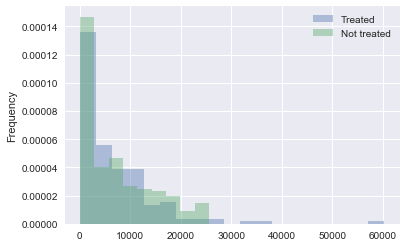

In [39]:
sns.distplot(norm_hist=True, kde=False, a=treat_re78, label='Treated')
sns.distplot(norm_hist=True, kde=False, a=notreat_re78, label='Not treated')
plt.ylabel('Frequency')
plt.legend()

We first notice from the first two plots that the distribution of the two groups have a similar shape, resembling an exponential distribution, while the third plot allows us to compare directly the values of `re78` in the two groups, we see that in proportion there are more individuals with a very low income (0 or close to 0) in the not treated group, whereas the treat group presents some outliers (income higher than 25000$). In order to check if the variable `re78` has an exponential distribution, we decide to plot our dataset in a loglog plot.

However, it is difficult to compare distributions using only histogram, beacuse they are influenced by the size of the group and don't give us any idea about how many people have an income under or over a certain threshold, so we decide to use boxplots in order to show more information.

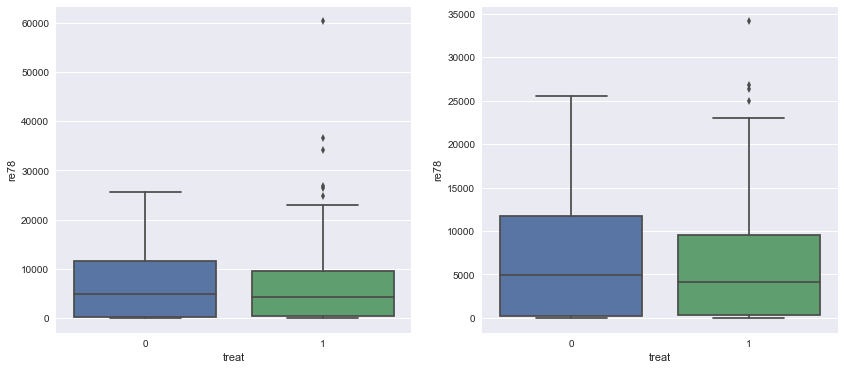

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))
sns.boxplot(x=df.treat,y=df.re78, ax=axs[0])
no_outliers=df[df['re78']<35000]
sns.boxplot(x=no_outliers.treat,y=no_outliers.re78, ax=axs[1])

In the former image,but since the distributions of the variable are high concentrated around lower values their differences aren't so clear, so we decided to remove two outliers(income higher than 35000$) from the dataset. Analysing the latter plots we can see that the medium value of income, the third quartile and the 0.90 quantile in the treated group is lower than the one in the other groups, which looks very strange. In fact the job training program is supposed to help people improve their income, but removing outliers it looks like that on average not attending the programm is better than attend it. However the first quantile is higher in the treated group, that could mean that many people after the job program find a job and increase a little their income, while most part of people who did not have a job and did not attend the program are still unemploied. 


### Numerical analysis

In [6]:
comparison=pd.DataFrame({'notreat' : notreat.describe().re78, 'treat' : treat.describe().re78,
                         'treat_no_outliers':no_outliers.loc[no_outliers.treat==1].describe().re78})

comparison

,notreat,treat,treat_no_outliers
count,429.000000,185.000000,183.000000
mean,6984.169742,6349.143530,5888.724990
std,7294.161791,7867.402218,6428.202899
min,0.000000,0.000000,0.000000
25%,220.181300,485.229800,387.509850
50%,4975.505000,4232.309000,4181.942000
75%,11688.820000,9642.999000,9578.521000
max,25564.670000,60307.930000,34099.280000


In [61]:
zero_treat = treat.loc[treat.re78==0].count().re78
n = treat.count().re78
zero_notreat = notreat.loc[notreat.re78==0].count().re78
m = notreat.count().re78
#fix
print("There are %d people without job in the treat group, %1.2f in percentage"  %(zero_treat, zero_treat/n*100))
print("There are %d people without job in the notreat group, %1.2f in percentage"  %(zero_notreat, zero_notreat/m*100))

There are 45 people without job in the treat group, 24.32 in percentage
There are 98 people without job in the notreat group, 22.84 in percentage


As before, numerical analysis confirms what we have found using boxplots, but now we have find out that the proportion of people without a job is similar between the two groups. Moreover we can notice that the mean of the two distribution is much higher that median, so it confirms that we have heavy-tailed datasets, as in exponential distributions.

In [58]:
#I did comparison with re75 by mistake, but this is not required, we have to decide if it's better to delete this part
treat_diff = treat.re78-treat.re75
notreat_diff= notreat.re78-notreat.re75
comparison7578=pd.DataFrame({'notreat' : notreat.describe().re78, 'treat' : treat.describe().re78,
            'diff_notreat' : notreat_diff.describe(), 'diff_treat' : treat_diff.describe()})

comparison7578

,diff_notreat,diff_treat,notreat,treat
count,429.000000,185.000000,429.000000,185.000000
mean,4517.685299,4817.088216,6984.169742,6349.143530
std,6917.542917,8275.409427,7294.161791,7867.402218
min,-13776.530000,-20960.298000,0.000000,0.000000
25%,0.000000,0.000000,220.181300,485.229800
50%,2688.385000,2787.960000,4975.505000,4232.309000
75%,8007.601100,8087.487000,11688.820000,9642.999000
max,25564.670000,59023.851000,25564.670000,60307.930000


In [59]:
percentage=pd.DataFrame({'Key':['better_notreat', 'worse_notreat','equal_notreat','better_treat','worse_treat','equal_treat'],
                        'Proportion':[notreat_diff.loc[notreat_diff>0].count()/m , notreat_diff.loc[notreat_diff<0].count()/m, 
                         notreat_diff.loc[notreat_diff==0].count()/m, treat_diff.loc[treat_diff>0].count()/n ,
                         treat_diff.loc[treat_diff<0].count()/n, treat_diff.loc[treat_diff==0].count()/n]}).set_index('Key')
percentage

,Proportion
Key,
better_notreat,0.662005
worse_notreat,0.240093
equal_notreat,0.097902
better_treat,0.670270
worse_treat,0.162162
equal_treat,0.167568


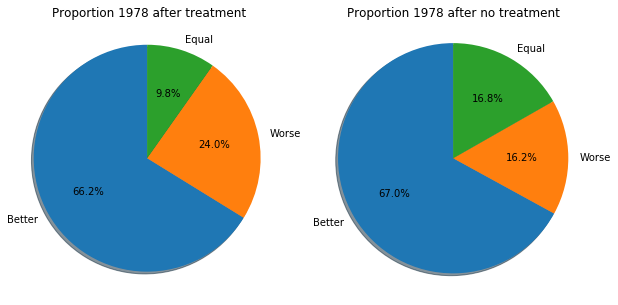

In [60]:
labels = ['Better', 'Worse', 'Equal']
fig1, axes = plt.subplots(1,2 ,figsize=(10, 5))
axes[0].set_title('Proportion 1978 after treatment')
axes[0].pie(percentage.Proportion[[0,1,2]], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].axis('equal') 
axes[1].set_title('Proportion 1978 after no treatment')
axes[1].pie(percentage.Proportion[[3,4,5]], labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
axes[1].axis('equal') 
plt.show()


#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.


### Numerical variables analysis

We decide to do different analysis for tha categorical and the numerical attributes, starting from the former. As before we use histograms to try to identify the distributions of the variables. Plots on the left refer to the group attending the job programm, while plots on the rigth represents characteristics of people not attending it.

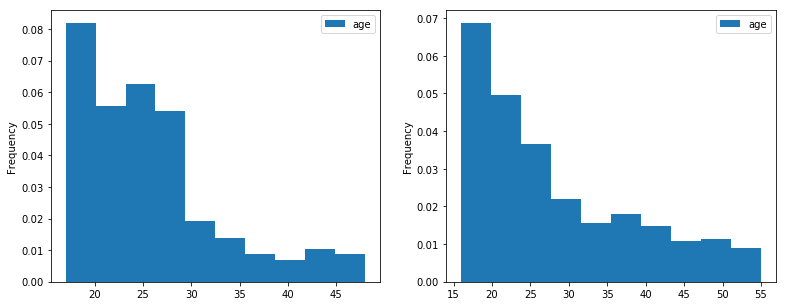

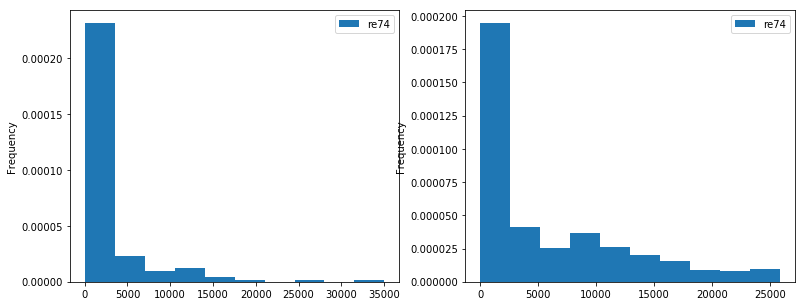

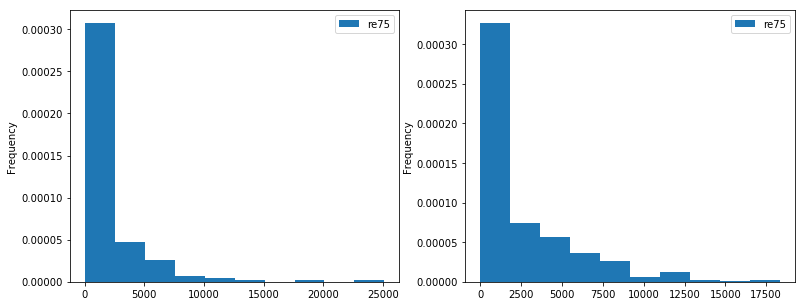

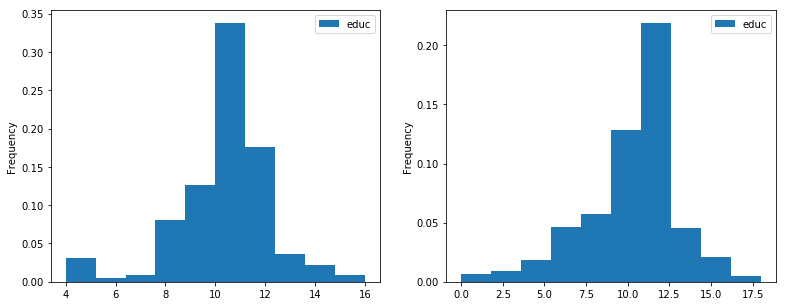

In [83]:
def plot_analysis(treat,notreat,attribute):
    treat_attribute = treat[[attribute]]
    notreat_attribute = notreat[[attribute]]
    fig, axes = plt.subplots(1, 2, figsize=(13, 5));
    treat_attribute.plot.hist(ax=axes[0],normed=1)
    notreat_attribute.plot.hist(ax=axes[1],normed=1)
    
plot_analysis(treat,notreat,'age')
plot_analysis(treat,notreat, 're74')  
plot_analysis(treat,notreat, 're75')  
plot_analysis(treat,notreat,'educ')


More people under 30 more with re74 and re75 under 5000...looks like esponential
educ has different minimum and maximum...looks like normal check using quantiles
Looking at the age plots, we can notice that in the treat group there are an higher density of pe

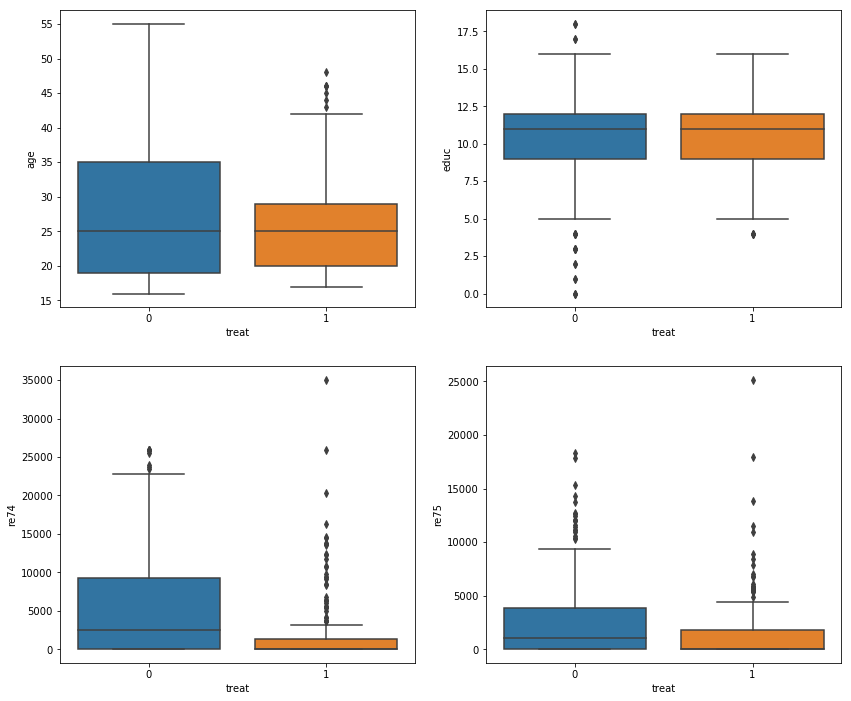

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12));
sns.boxplot(x=df.treat,y=df.age, ax=axes[0,0])
sns.boxplot(x=df.treat,y=df.re74, ax=axes[1,0])
sns.boxplot(x=df.treat,y=df.re75,ax=axes[1,1])
sns.boxplot(x=df.treat,y=df.educ,ax=axes[0,1])

age similar mean different quartiles all under fifty and more dense between 20-30
educ similar quartiles but it seems like they just remove outliers
re74re75 mean in treat group very close to 0 while other group still low but higher (3rd treat similar mean no treat)
re75 a 3rd e 90 a little higher but still lower than other group....present many outliers

In [11]:
treat.describe()

,age,educ,re74,re75,re78
count,185.000000,185.000000,185.000000,185.000000,185.000000
mean,25.816216,10.345946,2095.573689,1532.055314,6349.143530
std,7.155019,2.010650,4886.620353,3219.250870,7867.402218
min,17.000000,4.000000,0.000000,0.000000,0.000000
25%,20.000000,9.000000,0.000000,0.000000,485.229800
50%,25.000000,11.000000,0.000000,0.000000,4232.309000
75%,29.000000,12.000000,1291.468000,1817.284000,9642.999000
max,48.000000,16.000000,35040.070000,25142.240000,60307.930000


In [10]:
notreat.describe() 

,age,educ,re74,re75,re78
count,429.000000,429.000000,429.000000,429.000000,429.000000
mean,28.030303,10.235431,5619.236506,2466.484443,6984.169742
std,10.786653,2.855238,6788.750796,3291.996183,7294.161791
min,16.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,9.000000,0.000000,0.000000,220.181300
50%,25.000000,11.000000,2547.047000,1086.726000,4975.505000
75%,35.000000,12.000000,9277.128000,3881.419000,11688.820000
max,55.000000,18.000000,25862.320000,18347.230000,25564.670000


same results of box plts selection a range on age and educ

### Categorical variables analysis

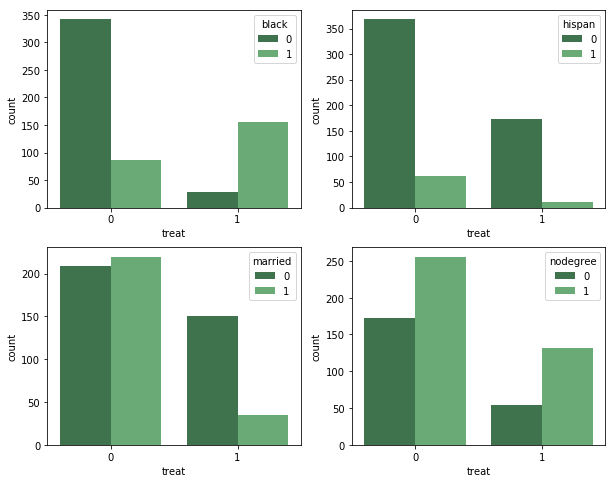

In [21]:
#aggiungi white
#non rende bene perchè non tiene conto del numero totale in treat and no treat-->piechart better
fig, axes = plt.subplots(2, 2, figsize=(10, 8));
sns.countplot(hue="black", x="treat", data=df, palette="Greens_d", ax=axes[0,0])
sns.countplot(hue="hispan", x="treat", data=df, palette="Greens_d" , ax=axes[0,1])
sns.countplot(hue="married", x="treat", data=df, palette="Greens_d", ax=axes[1,0])
sns.countplot(hue="nodegree", x="treat", data=df, palette="Greens_d", ax=axes[1,1])


In [24]:
num = treat.sum()
num2 = notreat.sum()
categorical=pd.DataFrame({'Key':['white','hispan','black','married','nodegree','total'],
                         'treat':[n-num.black-num.hispan , num.hispan,
                                            num.black, num.married, num.nodegree, n],
                         'notreat':[m-num2.black-num2.hispan , num2.hispan,
                                            num2.black, num2.married, num.nodegree, m],
                        'Proportion_treat':[(n-num.black-num.hispan)/n , num.hispan/n,
                                            num.black/n, num.married/n, num.nodegree/n,'-'],
                         'Proportion_notreat':[(m-num2.black-num2.hispan)/m , num2.hispan/m,
                                            num2.black/m, num2.married/m, num.nodegree/m, '-']
                        }).set_index('Key')
categorical

,Proportion_notreat,Proportion_treat,notreat,treat
Key,,,,
white,0.655012,0.0972973,281.0,18.0
hispan,0.142191,0.0594595,61.0,11.0
black,0.202797,0.843243,87.0,156.0
married,0.512821,0.189189,220.0,35.0
nodegree,0.305361,0.708108,131.0,131.0
total,-,-,429.0,185.0


In [50]:
black_treat=treat[treat['black']==1].sum()
hispan_treat=treat[treat['hispan']==1].sum()
black_notreat=notreat[notreat['black']==1].sum()
hispan_notreat=notreat[notreat['hispan']==1].sum()
#num = black.sum()
#white_treat=treat.loc['black'==0, 'hispan'==0]
#num2 = hispan.sum()


categorical=pd.DataFrame({'Key':['black_married','hispan_married','black_nodegree','hispan_nodegree','total'],
                         'treat':[black_treat.married , hispan_treat.married,
                                            black_treat.nodegree, hispan_treat.nodegree, n],
                         'notreat':[black_notreat.married , hispan_notreat.married,
                                            black_notreat.nodegree, hispan_notreat.nodegree, m],
                         'Proportion_treat':[black_treat.married/n , hispan_treat.married/n,
                                            black_treat.nodegree/n, hispan_treat.nodegree/n,'-'],
                         'Proportion_notreat':[black_notreat.married/m,hispan_notreat.married/m,
                                            black_notreat.nodegree/m, hispan_notreat.nodegree/m,'-'],
                         'Proportion_race_treat':[black_treat.married/black_treat.black ,
                                                  hispan_treat.married/hispan_treat.hispan,
                                            black_treat.nodegree/black_treat.black,
                                                  hispan_treat.nodegree/hispan_treat.hispan,'-'],
                         'Proportion_race_notreat':[black_notreat.married/black_notreat.black,
                                                    hispan_notreat.married/hispan_notreat.hispan,
                                            black_notreat.nodegree/black_notreat.black, 
                                                    hispan_notreat.nodegree/hispan_notreat.hispan,'-']
                        }).set_index('Key')
categorical

,Proportion_notreat,Proportion_race_notreat,Proportion_race_treat,Proportion_treat,notreat,treat
Key,,,,,,
black_married,0.0582751,0.287356,0.185897,0.156757,25.0,29.0
hispan_married,0.0675991,0.47541,0.272727,0.0162162,29.0,3.0
black_nodegree,0.130536,0.643678,0.724359,0.610811,56.0,113.0
hispan_nodegree,0.107226,0.754098,0.818182,0.0486486,46.0,9.0
total,-,-,-,-,429.0,185.0


most part black no degree or black no married (no married and no degree even in no treat population)
in treat there are more black than hispan and white, more no degree than degree, than in no treat population
after piecharts to better visualize results

In [71]:
def pie_chart(size,ax,title,group):
    sizes = [size, 1-size]
    labels = [title, 'no '+title]
    ax.set_title('Percentage of '+title+' people in '+group+' group')
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax.axis('equal')  

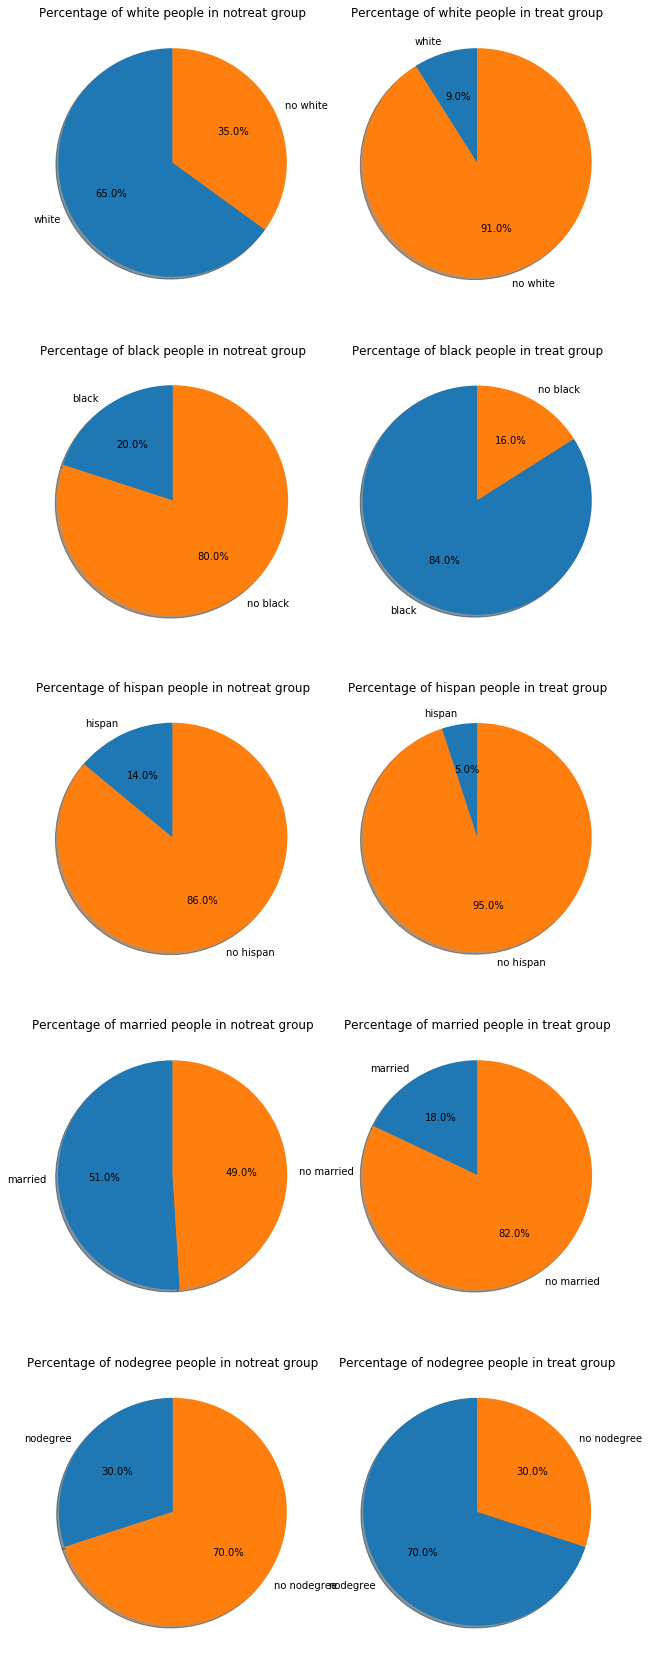

In [74]:
fig1, axes = plt.subplots(5,2 ,figsize=(10, 30))
pie_chart(0.65, axes[0,0], 'white', 'notreat')  
pie_chart(0.20, axes[1,0], 'black', 'notreat') 
pie_chart(0.14, axes[2,0], 'hispan', 'notreat') 
pie_chart(0.51, axes[3,0], 'married', 'notreat') 
pie_chart(0.30, axes[4,0], 'nodegree', 'notreat') 
pie_chart(0.09, axes[0,1], 'white', 'treat')  
pie_chart(0.84, axes[1,1], 'black', 'treat') 
pie_chart(0.05, axes[2,1], 'hispan', 'treat') 
pie_chart(0.18, axes[3,1], 'married', 'treat') 
pie_chart(0.70, axes[4,1], 'nodegree', 'treat') 
plt.show()

(-1.1035821631985938,
 1.1063908195004628,
 -1.1063721374534181,
 1.1003034351168295)

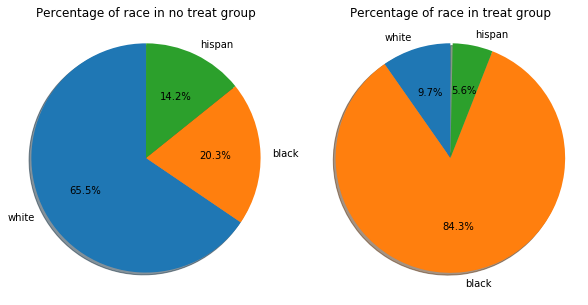

In [73]:
fig1, axes = plt.subplots(1,2 ,figsize=(10, 5))
labels = ['white','black','hispan']
sizes = [0.655, 0.2027, 0.1421]
ax = axes[0]
ax.set_title('Percentage of race in no treat group')
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  
sizes = [0.0972, 0.8432, 0.0564]
ax = axes[1]
ax.set_title('Percentage of race in treat group')
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)


In [80]:
#scrivi che è inutile aggiungere white perchè è già identificato da black=0 hispan=0
X = df.drop('treat', axis=1)
y = df.treat
logistic = LogisticRegression() # create the model
logistic.fit(X, y)  # train it

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [81]:
pred = logistic.predict_proba(X)
pred

array([[ 0.54192649,  0.45807351],
       [ 0.84801994,  0.15198006],
       [ 0.24903448,  0.75096552],
       ..., 
       [ 0.89944168,  0.10055832],
       [ 0.44954653,  0.55045347],
       [ 0.79880343,  0.20119657]])

In [82]:
df['prob_treat']=pred[:,1]
df['prob_notreat']=pred[:,0]
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prob_treat,prob_notreat
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.458074,0.541926
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.151980,0.848020
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.750966,0.249034
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.674020,0.325980
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.670590,0.329410


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?



In [ ]:
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(df.loc[df.treat==1].prob_treat, bipartite=0)
B.add_nodes_from(df.loc[df.treat==0].prob_treat, bipartite=1)
X,Y = bipartite.sets(B)


#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâ€“inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

